## Data

First we load the data, inspect it and remove columns we don't need:

In [23]:
## Importing modules
!pip install nltk
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install sklearn
import re, nltk, numpy, matplotlib
import pandas as pd
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.stem import WordNetLemmatizer, PorterStemmer, SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer 
from sklearn.decomposition import LatentDirichletAllocation
from gensim import corpora

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\analo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\analo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\analo\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [58]:
data = pd.read_csv("US_Debates_ngrams.csv")
data.head()
df = data.drop(columns=['Title', 'State', 'Volume', 'Where', 'Unnamed: 9', 'Unnamed: 11', 'Order']) # Remove columns
df. dropna() # Drop NA rows
len(df)

742

In [25]:
text =df['text'].apply(str) 
tokens = [" ".join(strings.split()) for strings in text] 
string = " ".join(tokens)
tokenized = word_tokenize(string)
len(tokenized)

468681

## Preprocessing
Now we can start preprocessing, by tokenising the corpus, removing puctuation and common stopwords, and converting the text into lower case.

In [26]:
stop_words_file = 'english.stop.txt' # Stopword list

stop_words = []

with open(stop_words_file, "r") as f:
    for line in f:
        stop_words.extend(line.split()) 
        
stop_words = stop_words  

def preprocess(raw_text):
    
    #regular expression keeping only letters 
    letters_only_text = re.sub("[^a-zA-Z]", " ", raw_text)

     # convert to lower case and split into words -> convert string into list
    words = letters_only_text.lower().split()
    words=[" ".join(words.split()) for words in words]   # remove double spaces by splitting the strings into words and joining these words again

    cleaned_words = []
    lemmatizer = WordNetLemmatizer() #plug in here any other stemmer or lemmatiser you want to try out
    
    # remove stopwords
    for word in words:
        if word not in stop_words:
            cleaned_words.append(word)
    
    # lemmatise words
    lemmatised_words = []
    for word in cleaned_words:
        word = nltk.stem.WordNetLemmatizer().lemmatize(word)  
        lemmatised_words.append(word)

    # converting list back to string
    return " ".join(lemmatised_words)

In [28]:
test_sentence = "this is a sentence to demonstrate how the preprocessing function works...!"

preprocess(test_sentence)

'sentence demonstrate preprocessing function work'

In [29]:
df['text']=df['text'].apply(str) # Converting text column into string so that preprocessing works

df['prep'] = df['text'].apply(preprocess)
df.head()

,Date,Speaker,Party,text,Congress,prep
0,"Thursday, January 3, 2013",Ms. SLAUGHTER,Democratic,Under the cover of a cynical and untruthful cl...,113th,cover cynical untruthful claim voter fraud thr...
1,"Thursday, February 14, 2013",Ms. JACKSON LEE,Democratic,"As a Member of this body, I firmly believe th...",113th,member body firmly protect right eligible citi...
2,"Thursday, February 14, 2013",Ms. JACKSON LEE,Democratic,There have been several restrictive voting bi...,113th,restrictive voting bill considered approved st...
3,"Thursday, February 14, 2014",Mr. VEASEY,Democratic,As oral arguments are being prepared for the F...,113th,oral argument prepared february supreme court ...
4,"Monday, February 25, 2013",Mr. JEFFRIES,Democratic,Perhaps the most relevant example of why secti...,113th,relevant section continues relevant due place ...


In [30]:
# Checking amount of words after preprocessing
text =df['prep'].apply(str) 
tokens = [" ".join(strings.split()) for strings in text] 
string = " ".join(tokens)
tokenized = word_tokenize(string)
len(tokenized)

178341

In [31]:
# Filtering words that appear less than 3 times overall, by (1) Splitting sentences into words, (2) Computing global word frequency, (3) Filtering words based on computed frequencies, (4) Joining and re-assigning
from collections import Counter
from itertools import chain

# split words into lists
v = df['prep'].str.split().tolist() # [s.split() for s in df['Col2'].tolist()]
# compute global word frequency
c = Counter(chain.from_iterable(v))
# filter, join, and re-assign
df['freq'] = [' '.join([j for j in i if c[j] > 3]) for i in v]

df.head()

,Date,Speaker,Party,text,Congress,prep,freq
0,"Thursday, January 3, 2013",Ms. SLAUGHTER,Democratic,Under the cover of a cynical and untruthful cl...,113th,cover cynical untruthful claim voter fraud thr...,cover cynical claim voter fraud threat democra...
1,"Thursday, February 14, 2013",Ms. JACKSON LEE,Democratic,"As a Member of this body, I firmly believe th...",113th,member body firmly protect right eligible citi...,member body firmly protect right eligible citi...
2,"Thursday, February 14, 2013",Ms. JACKSON LEE,Democratic,There have been several restrictive voting bi...,113th,restrictive voting bill considered approved st...,restrictive voting bill considered approved st...
3,"Thursday, February 14, 2014",Mr. VEASEY,Democratic,As oral arguments are being prepared for the F...,113th,oral argument prepared february supreme court ...,argument prepared february supreme court heari...
4,"Monday, February 25, 2013",Mr. JEFFRIES,Democratic,Perhaps the most relevant example of why secti...,113th,relevant section continues relevant due place ...,relevant section continues relevant due place ...


In [32]:
# Checking amount of words after preprocessing
text =df['freq'].apply(str) 
tokens = [" ".join(strings.split()) for strings in text] 
string = " ".join(tokens)
tokenized = word_tokenize(string)
len(tokenized)

169096

In [22]:
df.to_csv("lemma.csv") # save output to local machine

In [33]:
is_dem =  df['Party']=='Democratic'
dem = df[is_dem]
len(dem)

473

In [34]:
is_rep =  df['Party']=='Republican'
rep = df[is_rep]
len(rep)

269

In [35]:
text =dem['prep'].apply(str) 
tokens = [" ".join(strings.split()) for strings in text] 
string = " ".join(tokens)
tokenized = word_tokenize(string)
len(tokenized)

115022

## Descriptive stats

In [41]:
# Most frequent words
from collections import Counter
cnt = Counter()
for text in df["prep"].values:
    for word in text.split():
        cnt[word] += 1

# cnt = Counter(" ".join(df["prep"]).split(" ")).most_common(10) - another way of finding most common words in corpus

cnt.most_common(20)
cnt_df = pd.DataFrame(cnt.most_common(20))
cnt_df.columns=['word', 'freq']
cnt_df

,word,freq
0,state,3182
1,vote,2986
2,voter,2950
3,election,2907
4,voting,2371
5,american,1988
6,people,1895
7,law,1759
8,bill,1338
9,right,1186


In [44]:
# Displaying top words

import pandas as pd
import matplotlib.pyplot as plt
def scatterplot(df, x_dim, y_dim):
  x = df[x_dim]
  y = df[y_dim]
  fig, ax = plt.subplots(figsize=(10, 10))
  #customizes alpha for each dot in the scatter plot
  ax.scatter(x, y, alpha=0.70)
 
  #adds a title and axes labels
  ax.set_title('Word Frequencies')
  ax.set_xlabel('Frequency')
  ax.set_ylabel('Word')
 
  #removing top and right borders
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  #adds major gridlines
  ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
  plt.show()



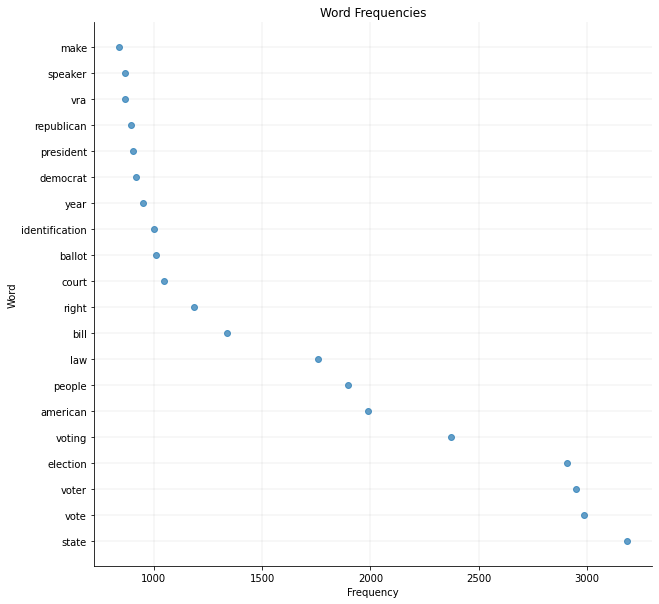

In [45]:
scatterplot(cnt_df, 'freq', 'word')

In [46]:
# find very infrequent words
cnt.most_common()[-10-1:-1]

[('transmission', 1),
 ('operator', 1),
 ('delicate', 1),
 ('activation', 1),
 ('obeying', 1),
 ('brazenly', 1),
 ('weakness', 1),
 ('blackmail', 1),
 ('dormancy', 1),
 ('capitulate', 1)]

In [47]:
# Find top bigrams with a frequency above 100
from nltk.util import ngrams
n_gram = 2
n_gram_dic = dict(Counter(ngrams(" ".join(df["prep"]).split(), n_gram))) # Finding ngrams in corpus

for i in n_gram_dic:
    if n_gram_dic[i] >= 100:
        print(i, n_gram_dic[i])


('voter', 'fraud') 218
('voter', 'identification') 541
('identification', 'law') 371
('cast', 'ballot') 103
('early', 'voting') 223
('minority', 'voter') 104
('photo', 'identification') 164
('election', 'day') 112
('voter', 'registration') 224
('african', 'american') 391
('state', 'local') 100
('election', 'law') 155
('voting', 'right') 679
('polling', 'place') 131
('supreme', 'court') 478
('shelby', 'county') 184
('voter', 'suppression') 363
('year', 'ago') 142
('mr', 'speaker') 332
('civil', 'right') 214
('voting', 'law') 148
('united', 'state') 294
('john', 'lewis') 205
('american', 'vote') 133
('people', 'vote') 103
('north', 'carolina') 250
('ballot', 'box') 108
('madam', 'speaker') 455
('federal', 'government') 163
('state', 'legislature') 163
('federal', 'election') 169
('american', 'people') 268
('right', 'advancement') 108
('advancement', 'act') 108
('presidential', 'election') 103
('vote', 'mail') 103
('president', 'trump') 131
('mr', 'farr') 109
('ballot', 'harvesting') 118


In [48]:
# Sorting ngrams by frequency
from nltk.util import ngrams
n_gram = 2
n_gram_dic = Counter(ngrams(" ".join(df["prep"]).split(), n_gram)).most_common(20) # 20 most common ngrams
ngram = pd.DataFrame(n_gram_dic)
ngram.columns=['ngram', 'freq']
ngram

,ngram,freq
0,"(voting, right)",679
1,"(voter, identification)",541
2,"(supreme, court)",478
3,"(madam, speaker)",455
4,"(african, american)",391
5,"(identification, law)",371
6,"(voter, suppression)",363
7,"(mr, speaker)",332
8,"(united, state)",294
9,"(american, people)",268


Now that we know common bigrams we can go back to preprocessing and join these in the text so that they are subsequently treated as 1 token instead of 2. 
The following bigrams are joined:
- Supreme court
- Madam speaker
- Mr Speaker
- United States
- North Carolina
- African American
- John Lewis



In [62]:
 def bigrams(raw_text):
    letters_only_text = raw_text.replace("supreme court", "supreme_court")
    letters_only_text = letters_only_text.replace("madam speaker", "madam_speaker")
    letters_only_text = letters_only_text.replace("mr speaker", "mr_speaker")
    letters_only_text = letters_only_text.replace("african american", "african_american")
    letters_only_text = letters_only_text.replace("north carolina", "north_carolina")
    letters_only_text = letters_only_text.replace("john lewis", "john_lewis")
    letters_only_text = letters_only_text.replace("united state", "united_states")
     # convert to lower case and split into words -> convert string into list
    words = letters_only_text.lower().split()
    words=[" ".join(words.split()) for words in words]   # remove double spaces by splitting the strings into words and joining these words again

    cleaned_words = []
    lemmatizer = WordNetLemmatizer() #plug in here any other stemmer or lemmatiser you want to try out
    
    # remove stopwords
    for word in words:
        if word not in stop_words:
            cleaned_words.append(word)
    
    # lemmatise words
    lemmatised_words = []
    for word in cleaned_words:
        word = nltk.stem.WordNetLemmatizer().lemmatize(word)  
        lemmatised_words.append(word)

    # converting list back to string
    return " ".join(lemmatised_words)

In [63]:
df['text']=df['text'].apply(str) # Converting text column into string so that preprocessing works

df['prep'] = df['text'].apply(bigrams)
df.head()

,Date,Speaker,Party,text,Congress,prep
0,"Thursday, January 3, 2013",Ms. SLAUGHTER,Democratic,Under the cover of a cynical and untruthful cl...,113th,cover cynical untruthful claim voter fraud thr...
1,"Thursday, February 14, 2013",Ms. JACKSON LEE,Democratic,"As a Member of this body, I firmly believe th...",113th,"member body, firmly protect right eligible cit..."
2,"Thursday, February 14, 2013",Ms. JACKSON LEE,Democratic,There have been several restrictive voting bi...,113th,restrictive voting bill considered approved st...
3,"Thursday, February 14, 2014",Mr. VEASEY,Democratic,As oral arguments are being prepared for the F...,113th,oral argument prepared february 27 u.s. suprem...
4,"Monday, February 25, 2013",Mr. JEFFRIES,Democratic,Perhaps the most relevant example of why secti...,113th,relevant section 5 continues relevant due plac...


In [ ]:
# this used to work but doesnt anymore
from pandas.core.frame import DataFrame
!pip install wordcloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt

all_words = '' 

#looping through all incidents and joining them to one text, to extract most common words
for arg in df["prep"]: 
    tokens = arg.split()  
    all_words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 1000, height = 1000, 
                background_color ='white', 
                min_font_size = 10).generate(all_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (10, 10), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

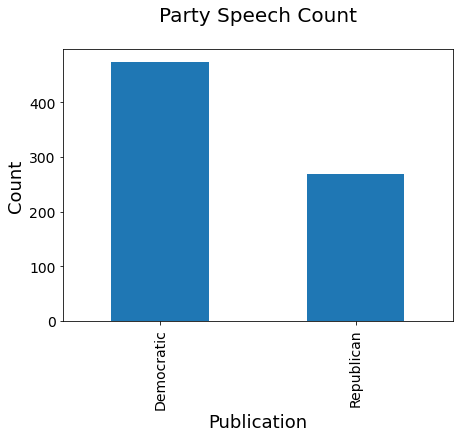

In [70]:
df['Party'].value_counts() # Counting speeches per Party

ax = data['Party'].value_counts().sort_index().plot(kind='bar', fontsize=14, figsize=(7,5))
ax.set_title('Party Speech Count\n', fontsize=20)
ax.set_xlabel('Publication', fontsize=18)
ax.set_ylabel('Count', fontsize=18);

In [71]:
congress = df['Congress'].value_counts()
pd.DataFrame(congress)

,Congress
117th,292
116th,232
115th,102
114th,74
113th,42


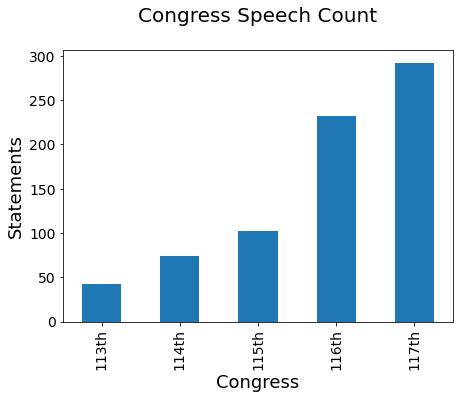

In [72]:
ax = df['Congress'].value_counts().sort_index().plot(kind='bar', fontsize=14, figsize=(7,5)) # Counting speeches per Congress
ax.set_title('Congress Speech Count\n', fontsize=20)
ax.set_xlabel('Congress', fontsize=18)
ax.set_ylabel('Statements', fontsize=18);

## POS

In [ ]:
import nltk
tagged = nltk.pos_tag(my_counter)
print(tagged)

### TF-IDF scores instead of word counts as features
Use (a) the frequency of each word in the corpus and (b) the number of documents in which the document occurs. So use tf-idf scores (term frequency weighed by the inverse document frequency) instead of raw word counts as features, the stopwords should disappear automatically.

In [75]:
text = df['prep'] # setting 'text' as the preprocessed corpus
orig = df['text']


While cv.fit(...) would only create the vocabulary, cv.fit_transform(...) creates the vocabulary and returns a term-document matrix which is what we want. With this, each column in the matrix represents a word in the vocabulary while each row represents the document in our dataset where the values in this case are the word counts. Note that with this representation, counts of some words could be 0 if the word did not appear in the corresponding document.

We ignore all words that have appeared in 95% of the documents, since those may be unimportant.

In [76]:
# ignore words that appear in 95% of documents and in less that 1% of documents,
cv=CountVectorizer(max_df=0.95, min_df =0.01)
word_count_vector=cv.fit_transform(text)

word_count_vector

<742x2874 sparse matrix of type '<class 'numpy.int64'>'
	with 102273 stored elements in Compressed Sparse Row format>

In [77]:
list(cv.vocabulary_.keys())[:10] #10 words from our vocabulary.

['cover',
 'cynical',
 'claim',
 'voter',
 'fraud',
 'threat',
 'democracy',
 'political',
 'operative',
 'state']

It’s now time to compute the IDF values. In the code below, we are essentially taking the sparse matrix from CountVectorizer (word_count_vector) to generate the IDF when you invoke tfidf_transformer.fit(...)(see: basic usage example of tfidftransformer and tfidfvectorizer).
Once we have our IDF computed, we are now ready to compute TF-IDF and then extract top keywords from the TF-IDF vectors. Now we are going to compute the IDF values. IDF values are be sorted in descending order. The lower the IDF value of a word, the less unique it is to any particular document.

In [78]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(word_count_vector)

TfidfTransformer()

In [79]:
# print idf values 
df_idf = pd.DataFrame(tfidf_transformer.idf_, index=cv.get_feature_names(),columns=["idf_weights"]) 
 
# sort ascending 
df_idf.sort_values(by=['idf_weights'])[:10]

C:\Users\analo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,idf_weights
voter,1.254588
vote,1.277416
state,1.317277
voting,1.354946
people,1.447381
american,1.472969
election,1.475131
law,1.535350
right,1.699899
identification,1.721818


Find most common words by Party 

In [86]:
cv=CountVectorizer(max_df=0.95, min_df =0.01)
word_count_vector_d=cv.fit_transform(dem['prep'])
tfidf_transformer_d=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer_d.fit(word_count_vector_d)
df_idf_d = pd.DataFrame(tfidf_transformer_d.idf_, index=cv.get_feature_names(),columns=["idf_weights"]) 
df_idf_d.sort_values(by=['idf_weights'])[:10]

C:\Users\analo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,idf_weights
voter,1.195061
vote,1.221036
voting,1.253124
state,1.306135
law,1.386656
american,1.415004
right,1.464114
people,1.512233
election,1.581477
court,1.651819


In [87]:
cv=CountVectorizer(max_df=0.95, min_df =0.01)
word_count_vector_r=cv.fit_transform(rep['prep'])
tfidf_transformer_r=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer_r.fit(word_count_vector_r)
df_idf_r = pd.DataFrame(tfidf_transformer_r.idf_, index=cv.get_feature_names(),columns=["idf_weights"]) 
df_idf_r.sort_values(by=['idf_weights'])[:10]

C:\Users\analo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,idf_weights
election,1.186776
state,1.218525
voter,1.300105
people,1.340927
vote,1.361980
american,1.416638
law,1.468523
bill,1.492476
voting,1.561469
identification,1.607989
